In [23]:
import pandas as pd
import numpy as np
import json
import pickle
import torch

from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
from scipy.stats import pearsonr
from scipy.stats import gaussian_kde

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import gridspec
import seaborn as sns

plt.rcParams['font.family'] = 'Times New Roman'

---
# Read in data

In [19]:
def get_position(mutation):
    pos = [_ for _ in mutation if _.isdigit()]
    pos = ''.join(pos)
    pos = int(pos)
    return pos

## Infectivity (Regression)

In [217]:
infectivity_date = '2024-02-05'

with open(f'model_infectivity/{infectivity_date}/mcmc_chain.pkl', 'rb') as f:
    inf_traces = pickle.load(f)
inf_data = torch.load(f'model_infectivity/{infectivity_date}/mcmc_input_data.pt')
inf_df = pd.DataFrame({'Mutation':inf_data['features'],
                       'μ_β':inf_traces['m'].mean(dim=0)})

## Escape (Regression)

In [138]:
escape_date = '2025-02-07'
sb = .01

escape_results = torch.load(f'model_covdb/results.{escape_date}.sb{sb}.pt')
escape_traces = escape_results['traces']
escape_data = escape_results['data']

escape_df = pd.DataFrame({'Mutation':escape_data['features'],
                         'μ_β':escape_traces['β'].mean(dim=0)})

escape_beta_df = pd.DataFrame({'Mutation':escape_data['features'],
                               'μ_β':escape_traces['β_ω'][:, 
                                                          (escape_data['pools_map']=='Beta').nonzero()[0][0], 
                                                          :].mean(dim=0)})
escape_omi_df = pd.DataFrame({'Mutation':escape_data['features'],
                              'μ_β':escape_traces['β_ω'][:, 
                                                         np.array([p in ['BA.1', 'BA.2.12.1', 'Omicron BA.4/5'] for p in escape_data['pools_map']]).nonzero()[0],
                                                         :].mean(dim=0).mean(dim=0)})

## EVEscape & EVE

In [55]:
# Read in EVEScape data
evescape = pd.read_csv('data/EVEscape/spike_evescape_predictions.csv').drop(columns='Unnamed: 0')
evescape['Mutation'] = evescape['wt'] + evescape['i'].astype(str) + evescape['mut']


## DMS

In [168]:
# Gather DMS data
dms_max = evescape[['Mutation', 'i', 'wt', 'mut', 'bloom_expression', 'bloom_ace2_binding', 
                    'chan_expression', 'chan_ace2_binding', 'max_escape_bloom', 'max_escape_xie']
                  ].dropna().reset_index(drop=True)
# dms['max_escape_bloom'] = np.exp(dms['max_escape_bloom'])

dms_all = pd.read_csv('data/DMS/agg_exp_dms_data_Jan22_2025.csv').rename(columns={'mutation':'mut', 'wildtype':'wt', 'site':'i'})
dms_all['Mutation'] = dms_all['wt'].astype(str) + dms_all['i'].astype(str) + dms_all['mut'].astype(str)

most_recent_variant = {
    # '2021_Greaney_Crowe_Abs',
    # '2021_Starr_REGN',
    # '2021_Greaney_HAARVI_sera',
    # '2021_Dong_AZ',
    # '2021_Starr_LY-CoV555',
    # '2021_Greaney_Rockefeller',
    # '2021_Starr_Vir',
    # '2021_Tortorici_S2X259',
    # '2021_Greaney_Moderna',
    '2021_Greaney_B1351':'Beta',
    # '2021_Greaney_COV2-2955',
    # '2021_Cao_Omicron',
    # '2022_Greaney_WuG_Delta_Beta_sera_mAbs':'PULL FROM SUPPLEMENT',
    # '2022_Cao_1640mAbs':'PULL FROM SUPPLEMENT',
    # '2022_Starr_WuG_BA1_BA2_1mAb',
    '2022_Cao_3051mAbs':'BA.2',
    # '2023_Dadonaite_delta_BA1_5mAb_2sera',
    # '2023_Yisimayi_1816mAbs':'PULL FROM SUPPLEMENT'
    '2024_Dadonaite_XBB15_10sera':'XBB'
    # '2024_Jian_2688mAbs':'PULL FROM SUPPLEMENT',
}

dms_beta = dms_all[dms_all['study']=='2021_Greaney_B1351'][
                              ['Mutation', 'wt', 'i', 'mut', 'mut_escape']
                              ].groupby(['Mutation', 'wt', 'i', 'mut']
                              ).agg('mean'
                              ).reset_index()
dms_ba2 = dms_all[dms_all['study']=='2022_Cao_3051mAbs'].reset_index(drop=True)
dms_xbb = dms_all[dms_all['study']=='2024_Dadonaite_XBB15_10sera'].reset_index(drop=True)
dms_omi = pd.concat([dms_ba2, dms_xbb])[['Mutation', 'wt', 'i', 'mut', 'mut_escape']
                              ].groupby(['Mutation', 'wt', 'i', 'mut']
                              ).agg('mean'
                              ).reset_index()

## Growth

In [84]:
# PyR0
pyro_file = 'data/PyR0/2023-09-19/mutations.tsv'
pyro = pd.read_csv(pyro_file, sep='\t', usecols=['mutation', 'R / R_A', 'R / R_A 95% ci lower', 'R / R_A 95% ci upper']).rename(columns={'mutation':'Mutation'})
pyro = pyro[pyro['Mutation'].str.startswith('S:')]
pyro['Mutation'] = pyro['Mutation'].apply(lambda x: x[2:])
pyro['Position'] = pyro['Mutation'].apply(lambda x: get_position(x))


# BVAS
bvas_file = 'data/BVAS/2023-09-20/allele_summary.csv'
bvas = pd.read_csv(bvas_file).rename(columns={'Unnamed: 0':'Mutation'}).drop(columns='Rank')
bvas = bvas[bvas['Mutation'].str.startswith('S:')]
bvas['Mutation'] = bvas['Mutation'].apply(lambda x: x[2:])
bvas['Position'] = bvas['Mutation'].apply(lambda x: get_position(x))

---
# Plot

In [275]:
def corr(x, y, df):
    series1 = df[[x,y]].dropna()[x]
    series2 = df[[x,y]].dropna()[y]
    R, p = pearsonr(series1, series2)
    return R, p

def annotate(ax, x, y, df, t, n=60):
    if len(df[[x,y,t]].dropna()) <= n:
        # Label all points
        for label in df[t].dropna():
            xi = df[x][df[t]==label].item()
            yi = df[y][df[t]==label].item()
            if not pd.isna(xi) and not pd.isna(yi):
                ax.text(xi, yi, label, rotation=20, fontsize=7)
                
    else:
        # # grab at most n outliers and label
        # labels = df.sort_values(by=x).head(int(n/4))[t].tolist() + \
        #          df.sort_values(by=x).tail(int(n/4))[t].tolist() + \
        #          df.sort_values(by=y).head(int(n/4))[t].tolist() + \
        #          df.sort_values(by=y).tail(int(n/4))[t].tolist()
        # for label in labels:
        #     xi = df[x][df[t]==label].item()
        #     yi = df[y][df[t]==label].item()
        #     if not pd.isna(xi) and not pd.isna(yi):
        #         ax.text(xi, yi, label, rotation=20, fontsize=7)
        temp = pd.concat([df.sort_values(by=x).head(int(n/4)),
                          df.sort_values(by=x).tail(int(n/4)),
                          df.sort_values(by=y).head(int(n/4)),
                          df.sort_values(by=y).tail(int(n/4))
                         ]).drop_duplicates()
        for _, row in temp.iterrows():
            if not pd.isna(row[x]) and not pd.isna(row[y]):
                ax.text(row[x], row[y], row[t], rotation=20, fontsize=7)
                
def plot_regions(ax):
    ylim = list(ax.get_ylim())
    ylim[1] = ylim[1] + 0.2 * (ylim[1] - ylim[0])
    regions = {'NTD':[13,304],
               'RBD':[417,505],
               # '':[438, 508], # RBM
               'FCS':[672,709],
               'FP':[788, 806],
               'IFP':[816, 833],
               'HR1':[918,983],
               'HR2':[1162,1203]}
    
    for r in regions:
        ax.vlines(regions[r], ylim[0], ylim[1], linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
        ax.fill_between(regions[r], ylim[0], ylim[1], color='tab:gray', alpha=0.1)
        ax.text(np.mean(regions[r]), ylim[0] + (ylim[1]-ylim[0])*0.95, r, ha='center', va='top', fontsize=7)
    ax.set_ylim(ylim)
                
def plot(x, y, df, t=None, logistic=False, **kwargs):
    fig, ax = plt.subplots(1, 1, figsize=(8,8))
    R, p = corr(x,y,df)
    sns.regplot(x=x,
                y=y,
                data=df,
                label='R={:.2f}\np={:.2e}'.format(R,p),
                logistic=logistic,
                ax=ax);
    ax.legend()

    # Annotate muts
    if t:
        annotate(ax, x, y, df, t, **kwargs)

    ax.set_title(f'{x} vs. {y} on {len(df[[x,y]].drop_duplicates())} mutations');
    
    return fig, ax

In [281]:
def metaplot(dfs, variables, variable_names):
    df1 = dfs[0]; df2 = dfs[1];
    var1 = variables[0]; var2 = variables[1];
    varn1 = variable_names[0]; varn2 = variable_names[1];
    comb_df = pd.merge(df1, df2, on='Mutation')
    
    # Create a figure
    fig = plt.figure(figsize=(14, 6))
    # Define the grid with specific height and width ratios
    gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1.2], height_ratios=[1, 1])
    f=8


    # Create the first column subplot (spanning all rows in the first column)
    ax1 = fig.add_subplot(gs[:, 0])
    R, p = corr(var1,var2,comb_df)
    ax1.scatter(comb_df[var1], comb_df[var2], s=20, color='tab:blue');
    sns.regplot(x=var1,
                y=var2,
                data=comb_df,
                label='R={:.2f}\np={:.2e}'.format(R,p),
                scatter=False,
                ax=ax1);
    annotate(ax1, var1, var2, comb_df, 'Mutation', n=30)
    ax1.legend(labels=['R={:.2f}\np={:.2e}'.format(R,p)])
    ax1.set_xlabel(varn1);
    ax1.set_ylabel(varn2);

    # Create the first column subplot (spanning all rows in the first column)
    ax2 = fig.add_subplot(gs[0, 1])
    outset = pd.merge(df1, comb_df, on='Mutation', how='left').rename(columns={f'{var1}_x':var1})
    outset = outset[outset[var2].isna()]
    positions = [int(''.join(filter(str.isdigit, c))) for c in outset['Mutation']]
    ax2.plot(positions, outset[var1], color='lightblue', marker='o', linestyle='')
    ax2.plot(comb_df['i'], comb_df[var1], color='darkblue', marker='o', linestyle='')
    for i, row in df1.sort_values(by=var1, ascending=False).reset_index(drop=True).iterrows():
        if i<10:
            pos = int(''.join([c for c in row['Mutation'] if c.isdigit()]))
            if len(row['Mutation']) < 15:
                ax2.text(pos, row[var1], row['Mutation'], fontsize=f)
        else:
            break
            
    plot_regions(ax2)
    ax2.set_xlabel('Position')
    ax2.set_ylabel(varn1);
    ax2.set_title(varn1);

    # Create the first column subplot (spanning all rows in the first column)
    ax3 = fig.add_subplot(gs[1, 1])
    outset = pd.merge(df2, comb_df, on='Mutation', how='left').rename(columns={f'{var2}_x':var2})
    outset = outset[outset[var1].isna()]
    positions = [int(''.join(filter(str.isdigit, c))) for c in outset['Mutation']]
    ax3.plot(positions, outset[var2], color='lightblue', marker='o', linestyle='')
    ax3.plot(comb_df['i'], comb_df[var2], color='darkblue', marker='o', linestyle='')
    for i, row in df2.sort_values(by=var2, ascending=False).reset_index(drop=True).iterrows():
        if i<10:
            ax3.text(row['i'], row[var2], row['Mutation'], fontsize=f)
        else:
            break
    plot_regions(ax3)
    ax3.set_xlabel('Position')
    ax3.set_ylabel(varn2);
    ax3.set_title(varn2);
    

    for ax in [ax2, ax3]:
        ax.set_xlim([0, 1273]);
        ax.spines[['right', 'top']].set_visible(False);

    fig.tight_layout()
    
    return [ax1, ax2, ax2]

## Immune Escape

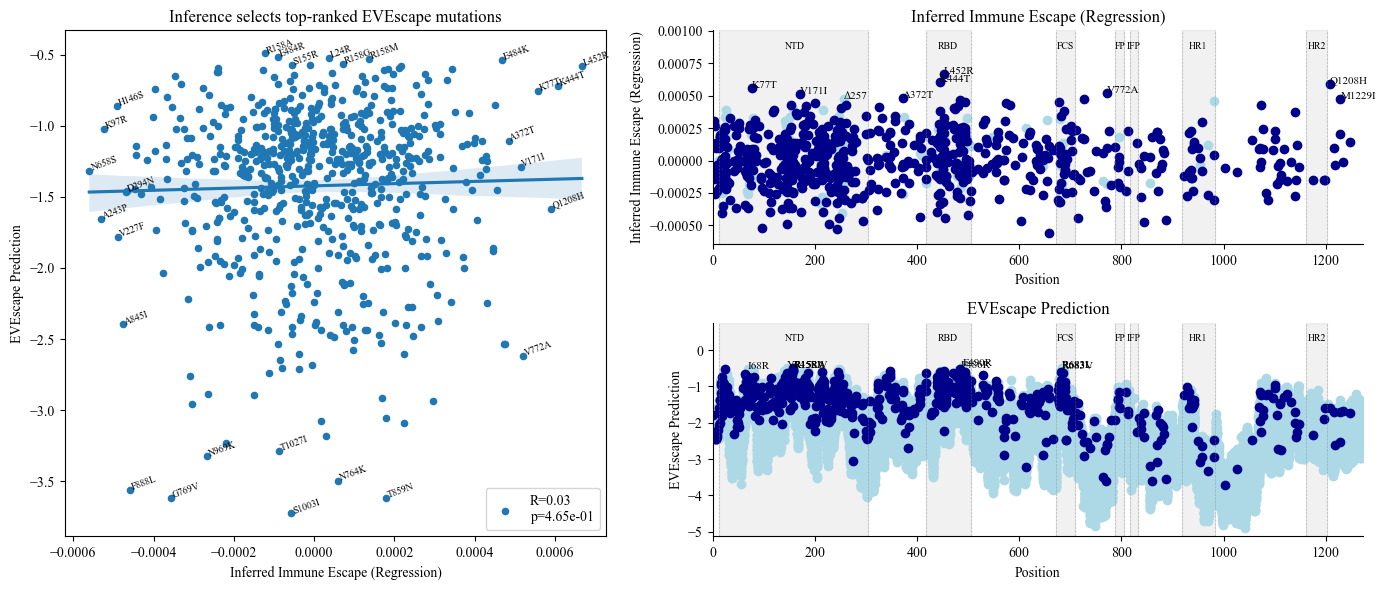

In [282]:
axes = metaplot([escape_df, evescape], 
                ['μ_β', 'evescape'], 
                ['Inferred Immune Escape (Regression)', 'EVEscape Prediction'])

axes[0].set_title('Inference selects top-ranked EVEscape mutations');

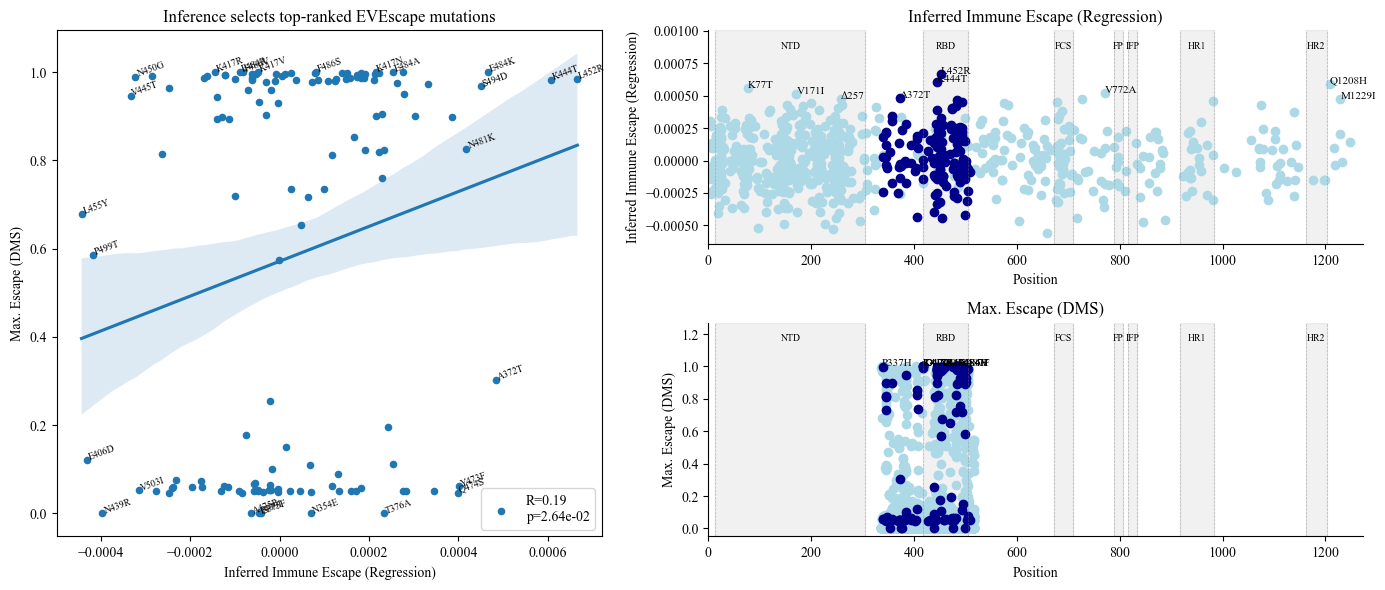

In [283]:
axes = metaplot([escape_df, dms_max], 
                ['μ_β', 'max_escape_bloom'], 
                ['Inferred Immune Escape (Regression)', 'Max. Escape (DMS)'])

axes[0].set_title('Inference selects top-ranked EVEscape mutations');

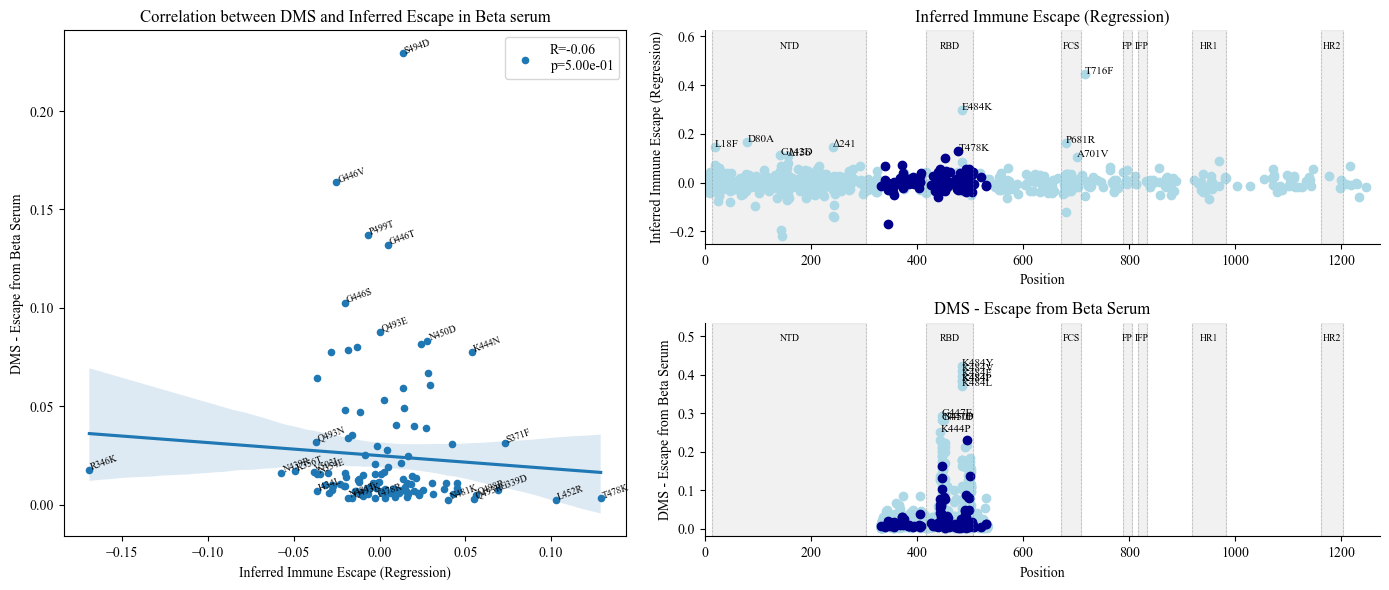

In [284]:
axes = metaplot([escape_beta_df, dms_beta], 
                ['μ_β', 'mut_escape'], 
                ['Inferred Immune Escape (Regression)', 'DMS - Escape from Beta Serum'])

axes[0].set_title('Correlation between DMS and Inferred Escape in Beta serum');

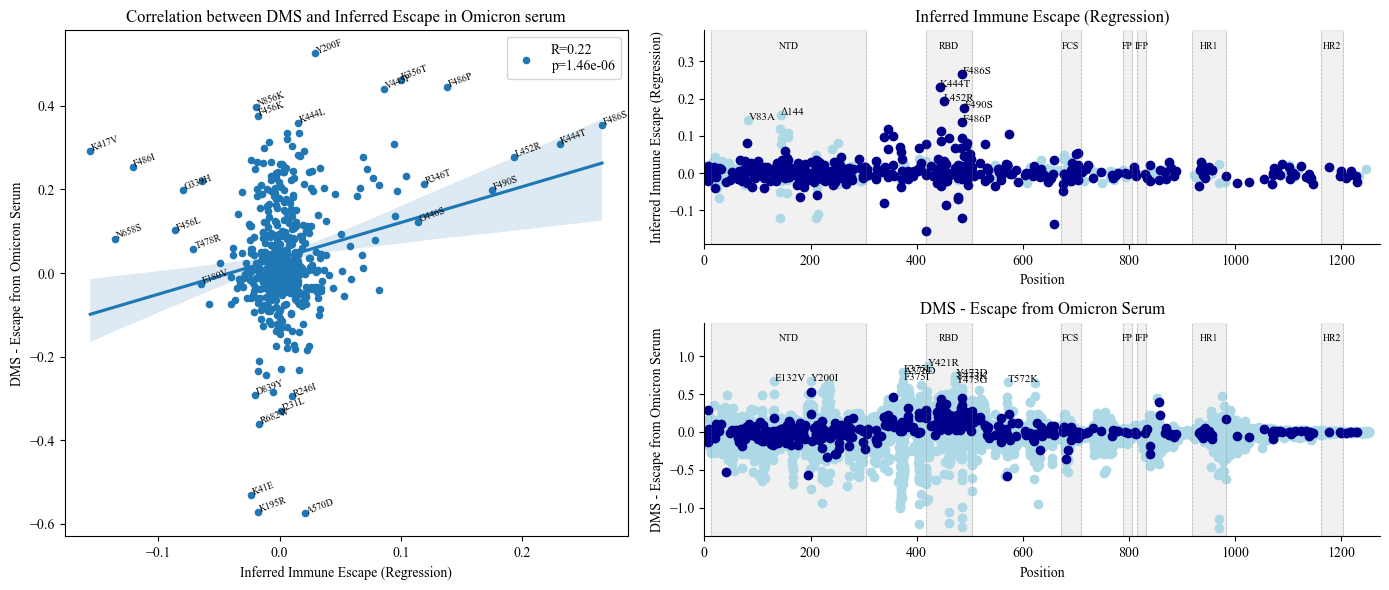

In [285]:
axes = metaplot([escape_omi_df, dms_omi], 
                ['μ_β', 'mut_escape'], 
                ['Inferred Immune Escape (Regression)', 'DMS - Escape from Omicron Serum'])

axes[0].set_title('Correlation between DMS and Inferred Escape in Omicron serum');

## Infectivity

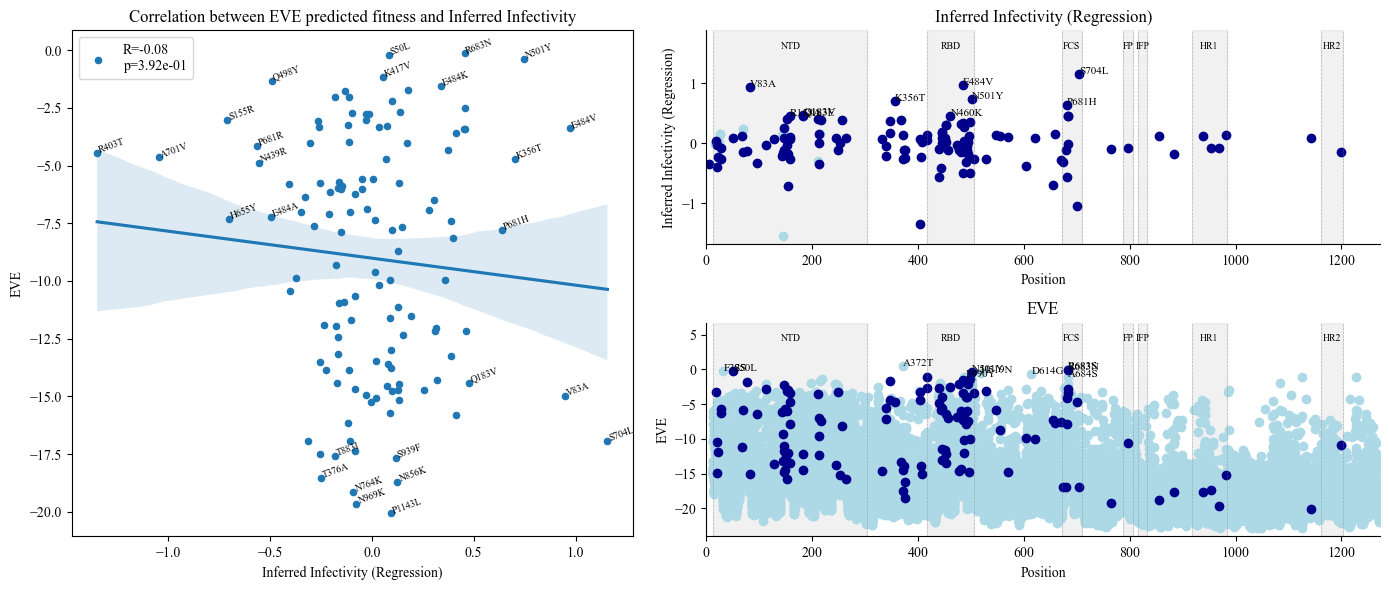

In [286]:
axes = metaplot([inf_df, evescape], 
                ['μ_β', 'eve'], 
                ['Inferred Infectivity (Regression)', 'EVE'])

axes[0].set_title('Correlation between EVE predicted fitness and Inferred Infectivity');

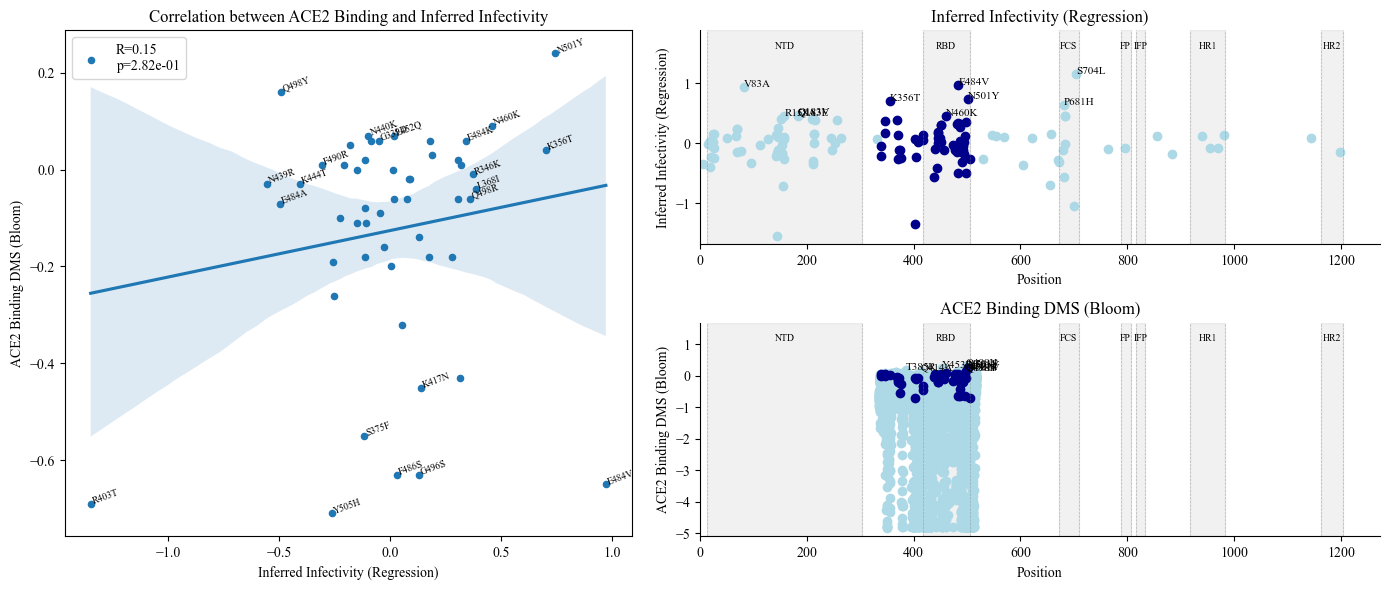

In [287]:
axes = metaplot([inf_df, dms_max], 
                ['μ_β', 'bloom_ace2_binding'], 
                ['Inferred Infectivity (Regression)', 'ACE2 Binding DMS (Bloom)'])

axes[0].set_title('Correlation between ACE2 Binding and Inferred Infectivity');

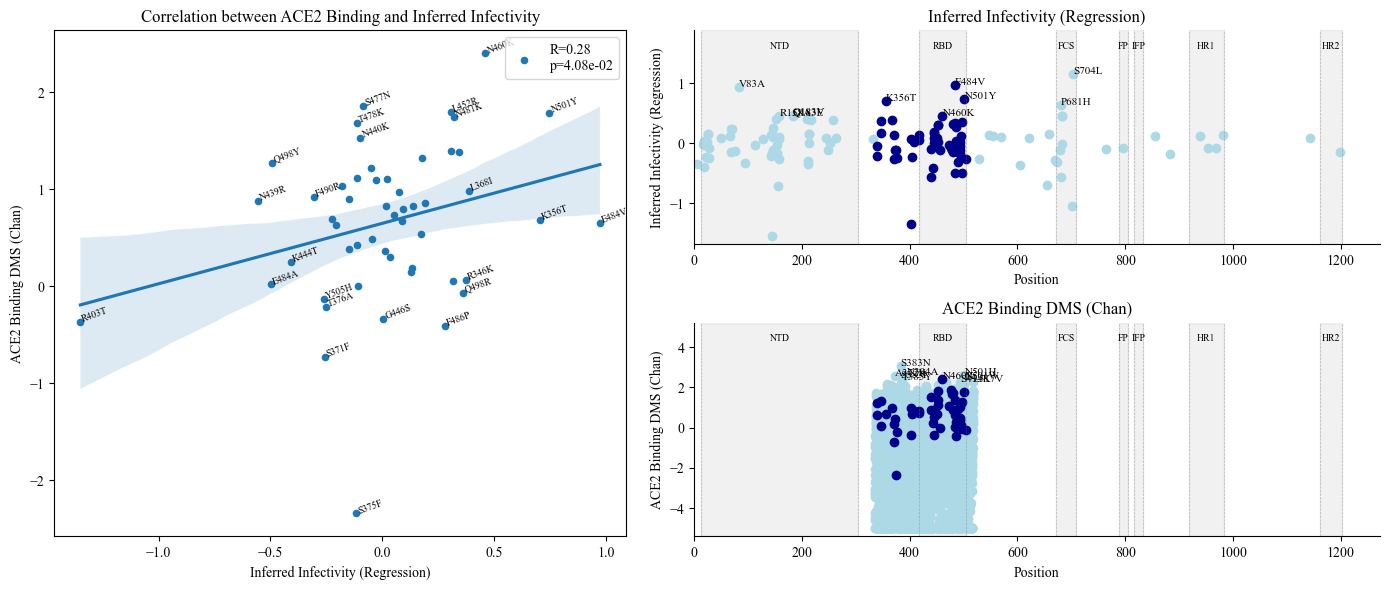

In [288]:
axes = metaplot([inf_df, dms_max], 
                ['μ_β', 'chan_ace2_binding'], 
                ['Inferred Infectivity (Regression)', 'ACE2 Binding DMS (Chan)'])

axes[0].set_title('Correlation between ACE2 Binding and Inferred Infectivity');

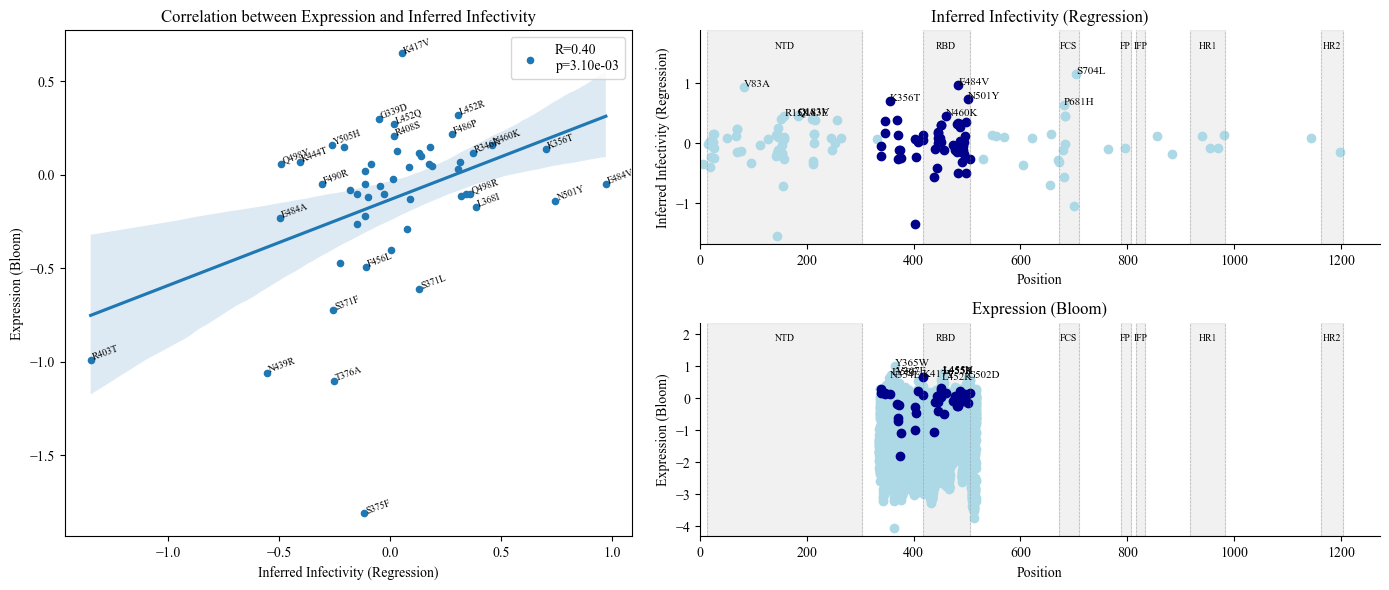

In [289]:
axes = metaplot([inf_df, dms_max], 
                ['μ_β', 'bloom_expression'], 
                ['Inferred Infectivity (Regression)', 'Expression (Bloom)'])

axes[0].set_title('Correlation between Expression and Inferred Infectivity');

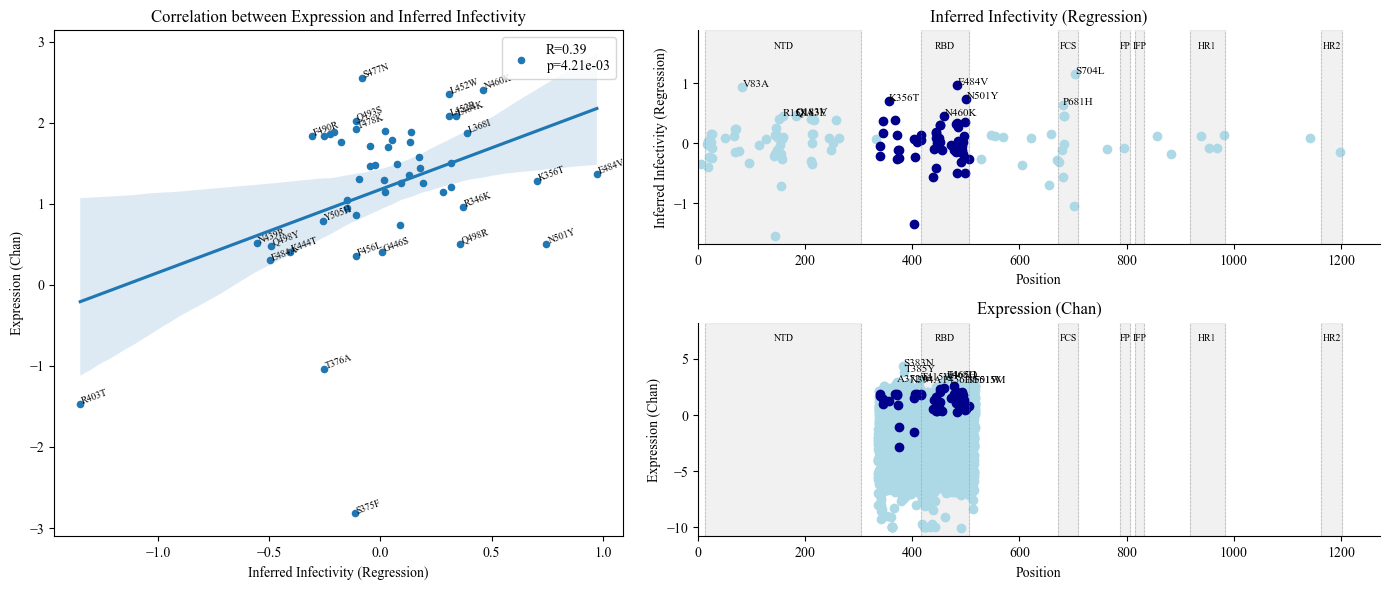

In [290]:
axes = metaplot([inf_df, dms_max], 
                ['μ_β', 'chan_expression'], 
                ['Inferred Infectivity (Regression)', 'Expression (Chan)'])

axes[0].set_title('Correlation between Expression and Inferred Infectivity');